# EECS16A Homework 6B

## Problem 3: Image Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

### Part (b)

In [ ]:
def plot_circle(a, d, e, color='r'):
    """
    You can use this function to plot circles with parameters a,d,e.
    The parameters are described in the homework pdf. 
    
    """
    is_circle = d**2 + e**2 + 4*a > 0
    assert is_circle, "Not a circle"
    
    XLIM_LO = -1
    XLIM_HI = 3
    YLIM_LO = -2
    YLIM_HI = 3
    X_COUNT = 400
    Y_COUNT = 400
    
    x = np.linspace(XLIM_LO, XLIM_HI, X_COUNT)
    y = np.linspace(YLIM_LO, YLIM_HI, Y_COUNT)
    x, y = np.meshgrid(x, y)
    f = lambda x,y: a*(x**2 + y**2) + d*x + e*y
    
    c1 = plt.contour(x, y, f(x,y), [1], colors=color)
    plt.axis('scaled')
    plt.xlabel('x')
    plt.ylabel('y')
    return c1

In [ ]:
def plot_ellipse(a, b, c, d, e, color='b'):
    """
    You can use this function to plot ellipses with parameters a-e.
    The parameters are described in the homework pdf. 
    """
    is_ellipse = b**2 - 4*a*c < 0
    assert is_ellipse, "Not an ellipse"
    
    XLIM_LO = -1
    XLIM_HI = 3
    YLIM_LO = -2
    YLIM_HI = 3
    X_COUNT = 400
    Y_COUNT = 400
    
    x = np.linspace(XLIM_LO, XLIM_HI, X_COUNT)
    y = np.linspace(YLIM_LO, YLIM_HI, Y_COUNT)
    x, y = np.meshgrid(x, y)
    f = lambda x,y: a*x**2 + b*x*y + c*y**2 + d*x + e*y
    
    c1 = plt.contour(x, y, f(x,y), [1], colors=color)
    plt.axis('scaled')
    plt.xlabel('x')
    plt.ylabel('y')
    return c1
    

In [ ]:
# Here is an example of plot_ellipse.
# This plots (x-1)**2 + (y-1)**2 = 1, 
# which is a circle centered at (1,1). 

plt.figure(figsize=(6,6))
plot_ellipse(-1, 0, -1, 2, 2)
plt.title('Ellipse with parameters (-1, 0, -1, 2, 2)')

### Part (c)

In [ ]:
xy = np.array([[0.3, -0.69],
               [0.5, 0.87],
               [0.9, -0.86],
               [1, 0.88],
               [1.2, -0.82],
               [1.5, .64],
               [1.8, 0]])
x = xy[:,0]
y = xy[:,1]

# New figure
plt.figure(figsize=(6,6))

# plot the data points
plt.scatter(x,y)

# First we compute our estimated coefficients
A = np.array([x**2+y**2,x,y]).T 
b = np.ones((7,))
circle_params = np.linalg.inv(np.transpose(A) @ A) @ np.transpose(A) @ b
##Alternative expression
#circle_params = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)
print(circle_params)

circ = plot_circle(circle_params[0], circle_params[1], circle_params[2])
plt.scatter(x,y, color='k')
plt.title('Data with least squares fit')

# Compute error
e = np.dot(A, circle_params) - b
print("e = {}\n".format(e))

e_magnitude = np.linalg.norm(e)

print("||e|| = {}\n".format(e_magnitude))
N = 7
print("||e|| / N = {}\n".format(e_magnitude / N))

### Part (d)

In [ ]:
# PART D

A = np.vstack((x**2, x*y, y**2, x, y)).T
b = np.ones((7,))
ellipse_params = np.linalg.inv(np.transpose(A) @ A) @ np.transpose(A) @ b
##Alternative expression
#ellipse_params = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)  
print(ellipse_params)

## Plotting the fitted circle and the fitted ellipse together
circ = plot_circle(circle_params[0], circle_params[1], circle_params[2])
plt.scatter(x,y, color='k')
ellipse = plot_ellipse(ellipse_params[0],ellipse_params[1],ellipse_params[2],ellipse_params[3],ellipse_params[4])
circ_leg,_ = circ.legend_elements()
elip_leg,_ = ellipse.legend_elements()
plt.legend([circ_leg[0], elip_leg[0]], ['Circle', 'Ellipse'])

# Compute error
e = np.dot(A, ellipse_params) - b
print("e = {}\n".format(e))

e_magnitude = np.linalg.norm(e)

print("||e|| = {}\n".format(e_magnitude))
N = 7
print("||e|| / N = {}\n".format(e_magnitude / N))

## Problem 4: GPS Receivers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import sys

In [2]:
## RUN THIS FUNCTION BEFORE YOU START THIS PROBLEM
## This function will generate the gold code associated with the satellite ID using linear shift registers
## The satellite_ID can be any integer between 1 and 24
def Gold_code_satellite(satellite_ID):
    codelength = 1023
    registerlength = 10
    
    # Defining the MLS for G1 generator
    register1 = -1*np.ones(registerlength)
    MLS1 = np.zeros(codelength)
    for i in range(codelength):
        MLS1[i] = register1[9]
        modulo = register1[2]*register1[9]
        register1 = np.roll(register1,1)
        register1[0] = modulo
    
    # Defining the MLS for G2 generator
    register2 = -1*np.ones(registerlength)
    MLS2 = np.zeros(codelength)
    for j in range(codelength):
        MLS2[j] = register2[9]
        modulo = register2[1]*register2[2]*register2[5]*register2[7]*register2[8]*register2[9]
        register2 = np.roll(register2,1)
        register2[0] = modulo
    
    delay = np.array([5,6,7,8,17,18,139,140,141,251,252,254,255,256,257,258,469,470,471,472,473,474,509,512,513,514,515,516,859,860,861,862])
    G1_out = MLS1;
    shamt = delay[satellite_ID - 1]
    G2_out = np.roll(MLS2,shamt)
    
    CA_code = G1_out * G2_out
    
    return CA_code

### Part (a)

In [3]:
def cross_correlation(array1, array2):
    """ This function should return two arrays or a matrix with one row corresponding to 
    the offset and other to the correlation value. array1 and array2 do not have to be
    arrays of equal length.
    Think of array1 as the received signal and array2 as the signature.
    The function should return correlation values as well as the indices of the nonzero values of the correlation
    Hint: look up np.correlate
    """

    #correlated_array = #Your code here (it is just one line) np.correlate(array1, array2, 'full')
    correlated_array = np.correlate(array1, array2, 'full')
    
    #Since both the arrays start at 0, the last "shift" where the signals overlap is the length of the first array
    end_index = len(array1)
    
    #Similarly, the first "shift" where the signals overlap is the negative of the length of the second array, offset by one because of the zero index.
    st_index = -len(array2) + 1
    
    indices = np.arange(st_index, end_index)    
    return (indices, correlated_array)

/Users/gkuo/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


Text(0, 0.5, 'Correlation value')

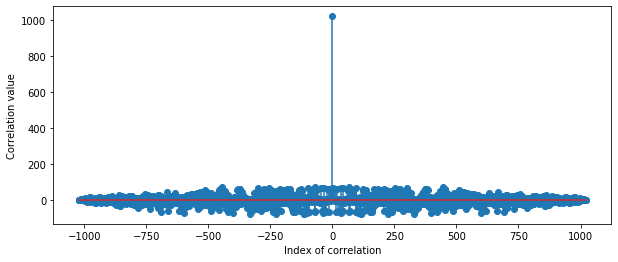

In [4]:
# Plot the auto-correlation of satellite 10 with itself. Fill in the function call.
array_10 = Gold_code_satellite(10)

(ind_10, self_10) = cross_correlation(array_10, array_10) #your code here

plt.figure(figsize=(10, 4))
plt.stem(ind_10, self_10)
plt.xlabel("Index of correlation")
plt.ylabel("Correlation value")

The autocorrelation peaks at 1023 when the signals are perfectly aligned (offset 0). The correlation of a Gold code with a shifted version of itself is not significant.

### Part (b) Plot the cross correlation when array1 = satellite 13 and array2 = satellite10

In [ ]:
#Your code here
array_13 = Gold_code_satellite(13)
(ind_10_13, cross_10_13) = cross_correlation(array_10, array_13)
plt.figure(figsize=(10, 4))
plt.stem(ind_10_13, cross_10_13)
plt.xlabel("Index of correlation")
plt.ylabel("Correlation value")

We see that the cross-correlation of a Gold code of any satellite with any other satellite is very low.  This indicates that when given some unknown data, we can differentiate between different satellites.

### Part (c)

In [ ]:
## THIS IS A HELPER FUNCTION FOR PART C THAT GENERATES +-1 RANDOM NOISE
def integernoise_generator(length_of_noise):
    noise_array = np.random.randint(2, size=length_of_noise)
    noise_array = 2 * noise_array - np.ones(len(noise_array))
    return noise_array

# YOUR CODE HERE
intrand_signal = integernoise_generator(1023)
(ind_intrand, cross_intrand) = cross_correlation(intrand_signal, array_10)
plt.figure(figsize=(10, 4))
plt.stem(ind_intrand, cross_intrand)
plt.xlabel("Index of correlation")
plt.ylabel("Correlation value")

We see that the cross-correlation of the Gold code of any satellite with integer noise is very low.  This indicates that we can still figure out the presence of a satellite even if it is buried in noise.

### Part (d)

In [ ]:
## THIS IS A HELPER FUNCTION FOR PART D THAT GENERATES REAL VALUED RANDOM NOISE
def gaussiannoise_generator(length_of_noise):
    noise_array = np.random.normal(0, 1, length_of_noise)
    return noise_array

# YOUR CODE HERE
gaussrand_signal = gaussiannoise_generator(1023)
(ind_gaussrand, cross_gaussrand) = cross_correlation(gaussrand_signal, array_10)
plt.figure(figsize=(10, 4))
plt.stem(ind_gaussrand, cross_gaussrand)
plt.xlabel("Index of correlation")
plt.ylabel("Correlation value")

We see that the Gold code of any satellite with Gaussian noise is very low.  This indicates that we can still figure out the presence of a satellite even if it is buried in Gaussian noise.

### Part (e)
Hint: you can use a absolute value threshold of 800 for the cross-correlation to detect if a given satellite is present. np.argwhere may be useful for detecting peak locations.

In [ ]:
#Now let us see which signals are present in the data signal that is in data1.npy
signal1 = np.load('data1.npy')

In [ ]:
#Here try plotting the cross-correlations of data1.npy with a few of the satellite gold codes. 
#How can you detect if the satellite is present?
(ind, corr) = cross_correlation(signal1, array_10)
plt.figure(figsize=(10, 4))
plt.stem(ind, corr)
plt.xlabel("Index of correlation")
plt.ylabel("Correlation value")

In [ ]:
## This helper function returns 1 if peak (greater than threshold or less than -threshold) is found, else it returns 0.
## You do not have to use this function as there are other solutions to this part as well

def find_peak(signal, threshold):
    max_value = np.amax(signal)
    min_value = np.amin(signal)
    if max_value > threshold:
        ret_value = 1
    elif min_value < -1 * threshold:
        ret_value = 1
    else:
        ret_value = 0
    return ret_value

In [ ]:
## USE 'np.load' FUNCTION TO LOAD THE DATA
## USE DATA1.NPY AS THE SIGNAL ARRAY
# YOUR CODE HERE
signal1 = np.load('data1.npy')
visible_sat_e = np.zeros(24)
thresh = 800
for sat_ID in np.arange(1,24):
    gold_code = Gold_code_satellite(sat_ID)
    (indices,correlation) = cross_correlation(signal1, gold_code)
    if find_peak(correlation, thresh):
            visible_sat_e[sat_ID - 1] = 1
            print('Visible:',sat_ID)

print(visible_sat_e)
print(np.argwhere(visible_sat_e)[:,0]+1)

The satellites that are present are satellites 4, 7, 13, and 19.

### Part (f)

In [ ]:
## USE DATA2.NPY AS THE SIGNAL ARRAY

# YOUR CODE HERE --- first write code to figure out which satellite is present
signal2 = np.load('data2.npy')
visible_sat_f = np.zeros(24)
thresh = 800

for sat_ID in np.arange(1, 24):
    gold_code = Gold_code_satellite(sat_ID)
    (indices, correlation) = cross_correlation(signal2, gold_code)
    visible_sat_f[sat_ID - 1] = find_peak(correlation, thresh)

print('Satellite: #', np.argwhere(visible_sat_f)[0][0]+1)
sat_num = np.argwhere(visible_sat_f)[0][0]+1

In [ ]:
## Once you have figured out which satellite is present, proceed to find the data transmitted
array_3 = Gold_code_satellite(sat_num)
(ind_3, sat3_data) = cross_correlation(signal2, array_3)
plt.figure(figsize=(10, 8))
plt.stem(ind_3, sat3_data)
## This tells us visually that the data is 1, -1, -1, -1, 1.

In [ ]:
## Another way to do this (which will come handy in the next part) is as follows:

## Find all 1s:
print(ind_3[np.argwhere(sat3_data > thresh)])

## Find all -1s:
print(ind_3[np.argwhere(sat3_data < -1 * thresh)])

## This again tells us that the data is 1, -1, -1, -1, 1.

Satellite 3 is transmitting 1, -1, -1, -1, 1.

### Part (g)

In [ ]:
## USE DATA3.NPY AS THE SIGNAL ARRAY

# YOUR CODE HERE
signal3 = np.load('data3.npy')
visible_sat_g = np.zeros(24)
thresh = 800
for sat_ID in np.arange(1, 24):
    gold_code = Gold_code_satellite(sat_ID)
    (indices, correlation) = cross_correlation(signal3, gold_code)
    visible_sat_g[sat_ID - 1] = find_peak(correlation, thresh)

print(visible_sat_g)
## This tells us that the satellites present in this data are 5 and 20. 

In [ ]:
array_5 = Gold_code_satellite(5)
(ind_5, sat5_data) = cross_correlation(signal3, array_5)

plt.figure(figsize=(10, 4))
plt.stem(ind_5, sat5_data)

In [ ]:
array_20 = Gold_code_satellite(20)
(ind_20, sat20_data) = cross_correlation(signal3, array_20)

plt.figure(figsize=(10, 4))
plt.stem(ind_20, sat20_data) 

In [ ]:
## We know that the data is 1, 1, -1, -1, -1, so we just find the positions of the first 1 in both the satellite correlations.
## Find all 1s:
sat5_ones = ind_5[np.argwhere(sat5_data > thresh)]
sat20_ones = ind_20[np.argwhere(sat20_data > thresh)]
print(sat5_ones)
print(sat20_ones)

## Problem 5: Targeted Promotion

### Part (d)

In [ ]:
import numpy as np

In [ ]:
def eeheeh_promotions(M_food, M_movies, M_art, M_books, sA1, sA2, sA3, sA4):

    M_total = M_food+M_movies+M_art+M_books
    T_food = M_food/M_total
    T_movies = M_movies/ M_total
    T_art = M_art/M_total
    T_books = M_books/M_total
    
    A=np.array([[0.4, 0.7, 0.2, 0.05], 
                [0.33, 0.1, 0.1, 0.02], 
                [0.22, 0.1, 0.15, 0.2], 
                [0.05, 0.1, 0.55, 0.73]])
    b=np.array([[T_food],[T_movies], [T_art], [T_books]])
    xc=np.linalg.solve(A, b)
    ip1 = np.inner(np.transpose(xc), np.transpose(sA1/np.linalg.norm(sA1)))
    ip2 = np.inner(np.transpose(xc), np.transpose(sA2/np.linalg.norm(sA2)))
    ip3 = np.inner(np.transpose(xc), np.transpose(sA3/np.linalg.norm(sA3)))
    ip4 = np.inner(np.transpose(xc), np.transpose(sA4/np.linalg.norm(sA4)))
    
    if ip1 == max(ip1, ip2, ip3, ip4):
        print('Promotion A1 will be printed.')
        s = sA1
    elif ip2 == max(ip1, ip2, ip3, ip4):
        print('Promotion A2 will be printed.')
        s = sA2
    elif ip3 == max(ip1, ip2, ip3, ip4):
        print('Promotion A3 will be printed.')
        s = sA3
    else:
        print('Promotion A4 will be printed.')
        s = sA4
    return (xc, s)

In [ ]:
sA1 = np.array([[1/2],[1/2], [-1/2], [1/2]])
sA2 = np.array([[2/3],[-1/2], [1/2], [1/3]])
sA3 = np.array([[-1/2],[-1/2], [5/2], [-1/2]])
sA4 = np.array([[0],[1/2], [0], [1/2]])
M_food = 6
M_movies = 4
M_art = 1
M_books = 5

eeheeh_promotions(M_food, M_movies, M_art, M_books, sA1, sA2, sA3, sA4)